# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


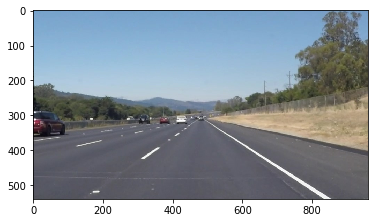

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [61]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray
    

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """   
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    NOTE: This is the initial version of the function used to 
    draw lines for the 'test images.' This function is NOT used 
    for the video portion of the project.
    """
    # List all x,y coordinates
    left_x1, left_y1 = [], []
    left_x2, left_y2 = [], []
    right_x1, right_y1 = [], []
    right_x2, right_y2 = [], []
        
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2-y1)/(x2-x1)
            # if slope is negative, update left line info
            if m < 0:
                left_x1.append(x1)
                left_y1.append(y1)
                left_x2.append(x2)
                left_y2.append(y2)
            # if slope is positive or zero, update right line info
            else:
                right_x1.append(x1)
                right_y1.append(y1)
                right_x2.append(x2)
                right_y2.append(y2)
    
    # Average x, y points
    left_x1_avg = (sum(left_x1) / len(left_x1)) if len(left_x1) != 0 else 0
    left_y1_avg = (sum(left_y1) / len(left_y1)) if len(left_y1) != 0 else 0
    left_x2_avg = (sum(left_x2) / len(left_x2)) if len(left_x2) != 0 else 0
    left_y2_avg = (sum(left_y2) / len(left_y2)) if len(left_y2) != 0 else 0
    
    right_x1_avg = (sum(right_x1) / len(right_x1)) if len(right_x1) != 0 else 0
    right_y1_avg = (sum(right_y1) / len(right_y1)) if len(right_y1) != 0 else 0
    right_x2_avg = (sum(right_x2) / len(right_x2)) if len(right_x2) != 0 else 0
    right_y2_avg = (sum(right_y2) / len(right_y2)) if len(right_y2) != 0 else 0

    # Slope denominators
    left_m_denom = left_x2_avg - left_x1_avg
    right_m_denom = right_x2_avg - right_x1_avg
    
    # Slope based on average points
    left_m_avg = (left_y2_avg - left_y1_avg) / left_m_denom
    right_m_avg = (right_y2_avg - right_y1_avg) / right_m_denom

    # Calculate y intercept (b)
    left_b = left_y1_avg - (left_m_avg * left_x1_avg)
    right_b = right_y1_avg - (right_m_avg * right_x1_avg)
    
    # Coordinates for extrapolated lines
    y_min = 320
    y_max = img.shape[0]

    x1_left = int((y_min - left_b) / left_m_avg)
    y1_left = y_min
    x2_left = int((y_max - left_b) / left_m_avg)
    y2_left = y_max
    
    x1_right = int((y_min - right_b) / right_m_avg)
    y1_right = y_min
    x2_right = int((y_max - right_b) / right_m_avg)
    y2_right = y_max
    
    # Draw lines
    cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)
    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [8]:
def render(image_name):
    '''This is the initial version of the function used to execute the line 
    drawing pipeline for the 'test images.'
    
    NOTE: This function is NOT used for processing a series of images within 
    a video clip. A separate function was created for that part of the project.
    '''
    # Read image and grayscale it
    image_orig = mpimg.imread('test_images/{}'.format(image_name))
    gray = grayscale(image_orig)

    # Define kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Detect edges via Canny algorithm
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create quadrilateral mask 
    imshape = image_orig.shape

    vert_bot_left = (150, imshape[0])
    vert_top_left = (450, 320)
    vert_top_right = (515, 320)
    vert_bot_right = (imshape[1], imshape[0])

    vertices = np.array([[vert_bot_left, vert_top_left, vert_top_right, vert_bot_right]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)

    # Define Hough transform parameters
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 60        # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60     # minimum number of pixels making up a line
    max_line_gap = 450    # maximum gap in pixels between connectable line segments

    # Draw lines
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Apply lines to original image as transparency
    lines_edges = weighted_img(lines, image_orig, α=0.8, β=1., λ=0.)
    plt.imshow(lines_edges)
    return lines_edges



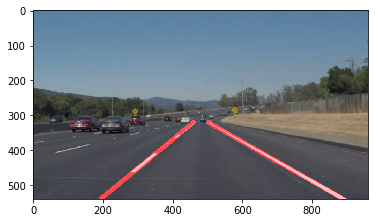

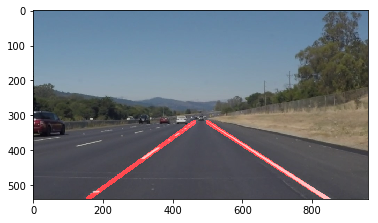

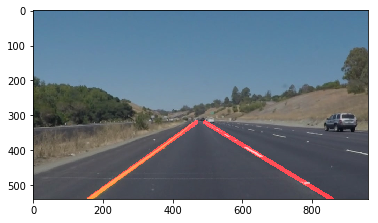

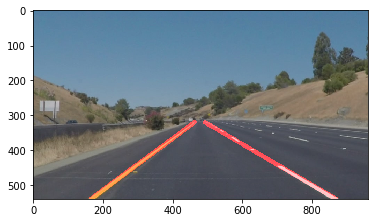

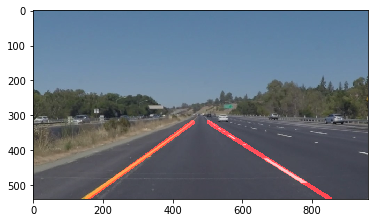

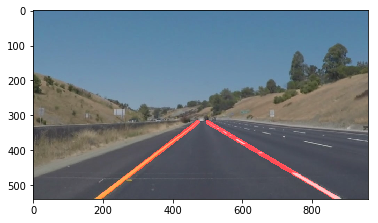

In [30]:
# Run all images through the pipeline
image_list = os.listdir("test_images/")

for image in image_list:
    plt.figure()
    render(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Modified Helper Functions for Video
The functions below are similar to ones used above for images, but these have been modified to handle cases encountered when displaying lines on video. In particular, the lines are now drawn using a moving average of the most recent coordinates.

In [54]:
# List of historical averages for lane line x, y coordinates
left_x1_hist, left_y1_hist = [], []
left_x2_hist, left_y2_hist = [], []

right_x1_hist, right_y1_hist = [], []
right_x2_hist, right_y2_hist = [], []
    

def draw_video_lines(img, lines, color=[255, 0, 0], thickness=12):
    """   
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    Lines are drawn using a moving average of most recent 'n' sets of 
    coordinates. If moving averages aren't available or the slope is not valid,
    the function draws the line using the last set of valid coordinates.
    
    """
    # List all x,y coordinates
    left_x1, left_y1 = [], []
    left_x2, left_y2 = [], []
    right_x1, right_y1 = [], []
    right_x2, right_y2 = [], []
        
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2-y1)/(x2-x1)
            # if slope is negative, update left line info
            if m < 0:
                left_x1.append(x1)
                left_y1.append(y1)
                left_x2.append(x2)
                left_y2.append(y2)
            # if slope is positive or zero, update right line info
            else:
                right_x1.append(x1)
                right_y1.append(y1)
                right_x2.append(x2)
                right_y2.append(y2)
    
    # Average x,y points
    left_x1_avg = (sum(left_x1) / len(left_x1)) if len(left_x1) != 0 else 0
    left_y1_avg = (sum(left_y1) / len(left_y1)) if len(left_y1) != 0 else 0
    left_x2_avg = (sum(left_x2) / len(left_x2)) if len(left_x2) != 0 else 0
    left_y2_avg = (sum(left_y2) / len(left_y2)) if len(left_y2) != 0 else 0
    
    right_x1_avg = (sum(right_x1) / len(right_x1)) if len(right_x1) != 0 else 0
    right_y1_avg = (sum(right_y1) / len(right_y1)) if len(right_y1) != 0 else 0
    right_x2_avg = (sum(right_x2) / len(right_x2)) if len(right_x2) != 0 else 0
    right_y2_avg = (sum(right_y2) / len(right_y2)) if len(right_y2) != 0 else 0

    # Slope denominators
    left_m_denom = left_x2_avg - left_x1_avg
    right_m_denom = right_x2_avg - right_x1_avg
    
    # Define y min and max
    y_min = 320
    y_max = img.shape[0]
    
    # Calculate lines if slope is valid
    if left_m_denom != 0:
        # Slope based on average points
        left_m_avg = (left_y2_avg - left_y1_avg) / left_m_denom        
        
        # Calculate y intercept (b)
        left_b = left_y1_avg - (left_m_avg * left_x1_avg)
        
        # Coordinates for extrapolated lines
        x1_left = int((y_min - left_b) / left_m_avg)
        y1_left = y_min
        x2_left = int((y_max - left_b) / left_m_avg)
        y2_left = y_max
        
        # Save line in history
        left_x1_hist.append(x1_left)
        left_y1_hist.append(y1_left)
        left_x2_hist.append(x2_left)
        left_y2_hist.append(y2_left)   
        
    if right_m_denom != 0:
        # Slope based on average points
        right_m_avg = (right_y2_avg - right_y1_avg) / right_m_denom

        # Calculate y intercept (b)
        right_b = right_y1_avg - (right_m_avg * right_x1_avg)

        # Coordinates for extrapolated lines
        x1_right = int((y_min - right_b) / right_m_avg)
        y1_right = y_min
        x2_right = int((y_max - right_b) / right_m_avg)
        y2_right = y_max

        # Save line in history
        right_x1_hist.append(x1_right)
        right_y1_hist.append(y1_right)
        right_x2_hist.append(x2_right)
        right_y2_hist.append(y2_right) 

    # Calculate moving averages
    n = 5  # recent number of frames to include
    
    left_x1_sma = int(sum(left_x1_hist[-n:]) / n)
    left_x2_sma = int(sum(left_x2_hist[-n:]) / n)
    left_y1_sma = int(sum(left_y1_hist[-n:]) / n)
    left_y2_sma = int(sum(left_y2_hist[-n:]) / n)
    
    right_x1_sma = int(sum(right_x1_hist[-n:]) / n)
    right_x2_sma = int(sum(right_x2_hist[-n:]) / n)
    right_y1_sma = int(sum(right_y1_hist[-n:]) / n)
    right_y2_sma = int(sum(right_y2_hist[-n:]) / n)
    
    # Draw lines 
    # use most recent coordinates if moving averages are not available
    if (len(left_x1_hist) < n):
        cv2.line(img, (left_x1_hist[-1], left_y1_hist[-1]), (left_x2_hist[-1], left_y2_hist[-1]), color, thickness)
        cv2.line(img, (right_x1_hist[-1], right_y1_hist[-1]), (right_x2_hist[-1], right_y2_hist[-1]), color, thickness)
    # but use moving averages by default
    else:
        cv2.line(img, (left_x1_sma, left_y1_sma), (left_x2_sma, left_y2_sma), color, thickness)
        cv2.line(img, (right_x1_sma, right_y1_sma), (right_x2_sma, right_y2_sma), color, thickness)
    
    
def hough_video_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` is the output of a Canny transform.
        
    Returns image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), \
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_video_lines(line_img, lines)  # modified draw function for video
    
    return line_img

### Video Pipeline

In [55]:
# Historical outputs from each step of the pipeline (see Appendix for more info)
gray_hist = []
blur_gray_hist = []
edges_hist = []
masked_edges_hist = []
lines_hist = []
lines_edges_hist = []

In [56]:
def process_image(image_orig):
    '''This function executes the line drawing pipeline for a series of images 
    which are then written into a video file.
    '''
    # Read image and grayscale it
    gray = grayscale(image_orig)
    gray_hist.append(gray)
    
    # Define kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    blur_gray_hist.append(blur_gray)

    # Detect edges via Canny algorithm
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    edges_hist.append(edges)

    # Create quadrilateral mask 
    imshape = image_orig.shape

    vert_bot_left = (150, imshape[0])
    vert_top_left = (450, 320)
    vert_top_right = (515, 320)
    vert_bot_right = (imshape[1], imshape[0])

    vertices = np.array([[vert_bot_left, vert_top_left, vert_top_right, vert_bot_right]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)
    masked_edges_hist.append(masked_edges)

    # Define Hough transform parameters
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 60        # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60     # minimum number of pixels making up a line
    max_line_gap = 450    # maximum gap in pixels between connectable line segments

    # Draw lines
    lines = hough_video_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    lines_hist.append(lines)

    # Apply lines to original image as transparency
    lines_edges = weighted_img(lines, image_orig, α=0.8, β=1., λ=0.)
    lines_edges_hist.append(lines_edges)

    
    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [57]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 64.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.48 s, sys: 1.19 s, total: 3.67 s
Wall time: 4.01 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [59]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 58.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.87 s, sys: 3.63 s, total: 11.5 s
Wall time: 12 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

---

## Writeup and Submission

Here is a [link](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/1-lane-lines/P1-writeup.md) to my writeup for this project.


---

# Appendix

### Output from each step of the pipeline

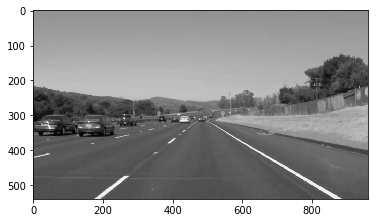

In [48]:
# Step 1 - convert image to grayscale
plt.imshow(gray_hist[-50], cmap='gray')

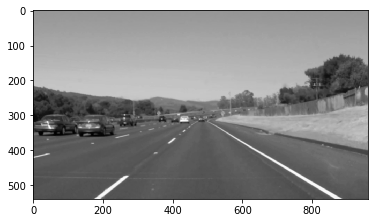

In [49]:
# Step 2 - apply Gaussian blur
plt.imshow(blur_gray_hist[-50], cmap='gray')

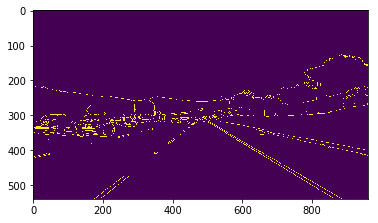

In [50]:
# Step 3 - apply the Canny transform
plt.imshow(edges_hist[-50])

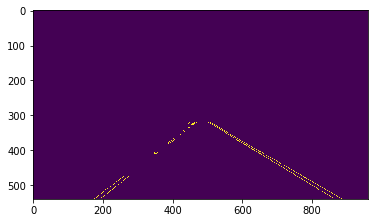

In [51]:
# Step 4 - apply mask to define 'region of interest'
plt.imshow(masked_edges_hist[-50])

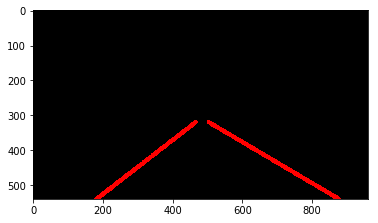

In [52]:
# Step 5a - detect lanes using Hough transform and draw lines on new image
plt.imshow(lines_hist[-50])

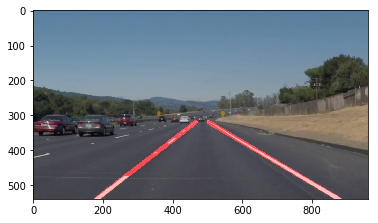

In [53]:
# Step 5b - apply lines to original image as transparency
plt.imshow(lines_edges_hist[-50])

---

# Optional Challenge -- *did not complete*

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 99%|█████████▉| 125/126 [00:04<00:00, 25.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.14 s, sys: 1.09 s, total: 5.23 s
Wall time: 5.85 s


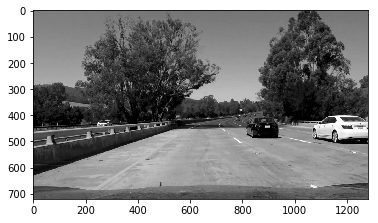

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))